**Project Statement:**   
Oil spills pose a serious threat to marine ecosystems, coastal regions, and local economies. Traditional
detection methods such as satellite image manual inspection or physical patrolling are time
consuming, labor-intensive, and often delayed. This project aims to develop an AI-powered oil spill
detection system using machine learning and satellite imagery to identify and localize oil spills
efficiently and accurately. Leveraging deep learning models such as CNNs or U-Net, the system will
analyze satellite images to detect oil spill patterns and generate segmentation maps for real-time
monitoring. This approach helps in early intervention, reducing environmental damage and supporting
emergency response.


**Outcomes**: The goal is to develop an AI-powered system that:

*   Automatically detects and segments oil spills in satellite images
*   Learns visual patterns specific to oil-contaminated regions using deep Learning
*   Produces clear segmentation masks highlighting affected areas
Assists environmental monitoring agencies in rapid oil spill detection and  intervention
*   Is deployable via a user-friendly interface for real-time use

Module 1: Data Collection

• Acquire satellite image datasets such as Sentinel-1 SAR, MODIS, or NOAA.

• Dataset Used: Oil Spill Detection Dataset on Kaggle

• Obtain labeled oil spill annotations from open environmental datasets or manually create custom segmentation masks for training.

• Organize the dataset into a structured format with separate directories for training, validation, and testing.

**NOTE**: Different dataset with pre-seggregated images & masks for Training, Testing and Validation is being used because of dataset size download issues.


In [18]:
#STEP1: Manually download the dataset into PC
#STEP2: Upload to Google Drive
#STEP3: Mount the Google Drive and processing the dataset from Google Drive

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Module 2: Data Exploration and Data Preprocessing

• Visualize sample satellite images and study statistical properties of spill and non-spill regions.

• Resize images to standard dimensions (e.g., 256x256).

• Normalize pixel values and apply SAR-specific filters such as speckle noise reduction.

• Augment dataset through techniques like flipping, rotating, scaling, and
brightness/contrast variation.


In [19]:
# Oil Spill Dataset - Exploration + Preprocessing
# -----------------------------------------------

#Import required Packages
import os, glob, cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [20]:
# 1. Dataset paths
# ----------------------------
dataset_path = "/content/drive/MyDrive/Oil_Spill_dataset"

# Training / Validation / Test
train_images = os.path.join(dataset_path, "train/images")
train_masks  = os.path.join(dataset_path, "train/masks")

val_images   = os.path.join(dataset_path, "val/images")
val_masks    = os.path.join(dataset_path, "val/masks")

test_images  = os.path.join(dataset_path, "test/images")
test_masks   = os.path.join(dataset_path, "test/masks")

# Sample check (printing first 5 files, Helps confirm that files are properly loaded.)
print("Train Images (5):", os.listdir(train_images)[:5])
print("Train Masks (5):", os.listdir(train_masks)[:5])

# Collect file paths
train_img_paths = sorted(glob.glob(os.path.join(train_images, "*.jpg")))
train_mask_paths = sorted(glob.glob(os.path.join(train_masks, "*.png")))

val_img_paths = sorted(glob.glob(os.path.join(val_images, "*.jpg")))
val_mask_paths = sorted(glob.glob(os.path.join(val_masks, "*.png")))

test_img_paths = sorted(glob.glob(os.path.join(test_images, "*.jpg")))
test_mask_paths = sorted(glob.glob(os.path.join(test_masks, "*.png")))

print("Train:", len(train_img_paths), "images,", len(train_mask_paths), "masks")  #this checks number of images and masks for all sets
print("Val:", len(val_img_paths), "images,", len(val_mask_paths), "masks")
print("Test:", len(test_img_paths), "images,", len(test_mask_paths), "masks")

#If images and masks match in count. If the dataset is balanced across splits.

Train Images (5): ['Oil (1031).jpg', 'Oil (1004).jpg', 'Oil (1081).jpg', 'Oil (104).jpg', 'Oil (1052).jpg']
Train Masks (5): ['Oil (1027).png', 'Oil (1089).png', 'Oil (1034).png', 'Oil (104).png', 'Oil (1005).png']
Train: 811 images, 811 masks
Val: 203 images, 203 masks
Test: 254 images, 254 masks


Image: /content/drive/MyDrive/Oil_Spill_dataset/train/images/Oil (1).jpg
Mask: /content/drive/MyDrive/Oil_Spill_dataset/train/masks/Oil (1).png


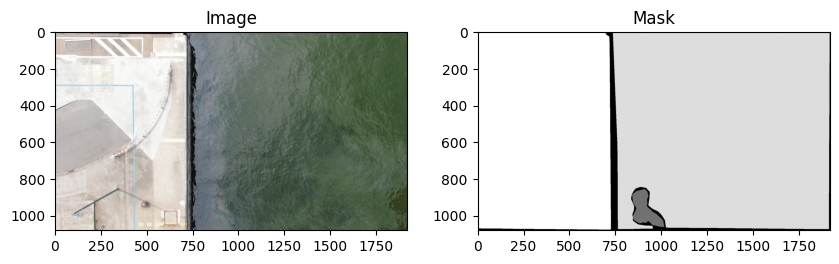

In [21]:
import matplotlib.pyplot as plt
import cv2

# Pick first pair
img_path = train_img_paths[0]
mask_path = train_mask_paths[0]

print("Image:", img_path)
print("Mask:", mask_path)

# Read
image = cv2.imread(img_path)
mask = cv2.imread(mask_path, 0)  # grayscale

# Plot
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Image")

plt.subplot(1,2,2)
plt.imshow(mask, cmap="gray")
plt.title("Mask")
plt.show()


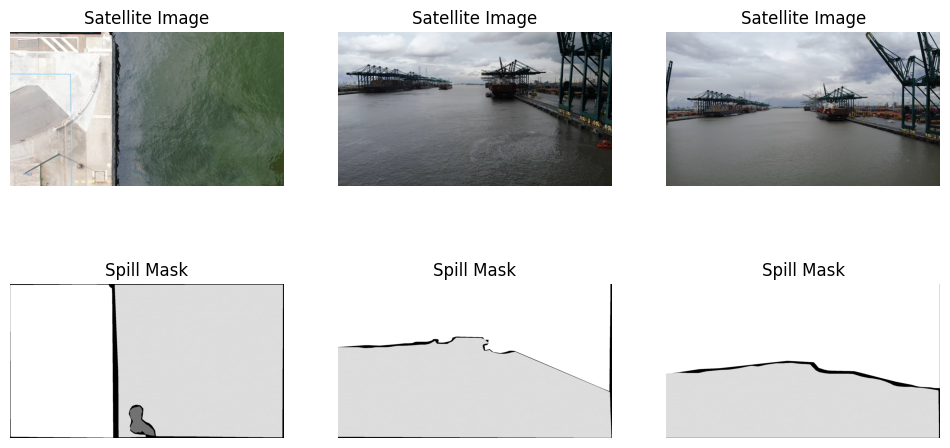

In [22]:
# ----------------------------
# 2. Visualize sample images + masks
# ----------------------------
def show_samples(img_paths, mask_paths, n=3):
    plt.figure(figsize=(12, 6))
    for i in range(n):
        img = cv2.imread(img_paths[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_paths[i], cv2.IMREAD_GRAYSCALE)

        plt.subplot(2, n, i+1)
        plt.imshow(img)
        plt.title("Satellite Image")
        plt.axis("off")

        plt.subplot(2, n, i+1+n)
        plt.imshow(mask, cmap="gray")
        plt.title("Spill Mask")
        plt.axis("off")
    plt.show()

show_samples(train_img_paths, train_mask_paths, n=3)

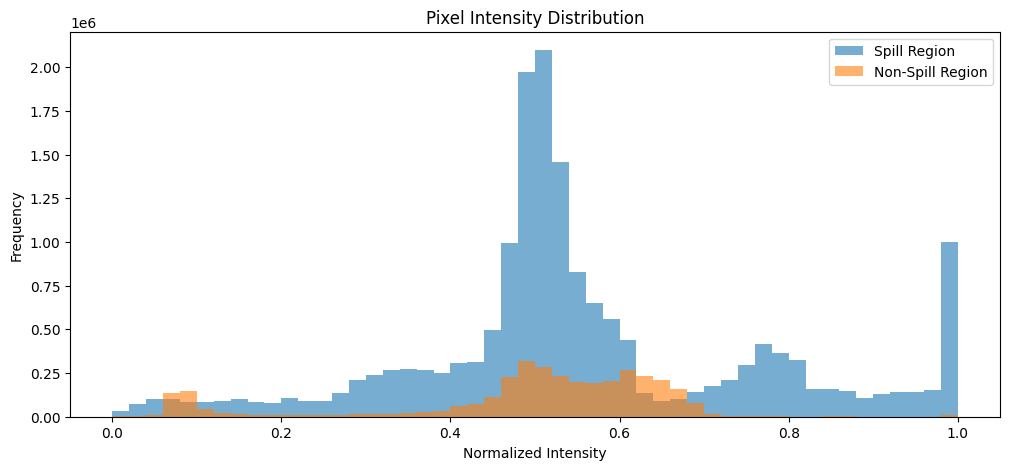

'\nYou’ll see two distributions:\n\nSpill region intensity distribution.\n\nNon-spill region intensity distribution.\n\nIf they are separated, it means the model can easily learn to distinguish oil spills based on pixel brightness.\n\nIf they overlap heavily, then you’ll need more advanced features (texture, context, deep CNN) for segmentation.'

In [23]:
# ----------------------------
# 3. Statistical properties
# ----------------------------
def analyze_statistics(img_paths, mask_paths, n=10):
    spill_pixels, nonspill_pixels = [], []

    for i in range(min(n, len(img_paths))):
        img = cv2.imread(img_paths[i], cv2.IMREAD_GRAYSCALE) / 255.0
        mask = cv2.imread(mask_paths[i], cv2.IMREAD_GRAYSCALE)
        mask = (mask > 127).astype(np.uint8)

        spill_pixels.extend(img[mask == 1].flatten())
        nonspill_pixels.extend(img[mask == 0].flatten())

    plt.figure(figsize=(12, 5))
    plt.hist(spill_pixels, bins=50, alpha=0.6, label="Spill Region")
    plt.hist(nonspill_pixels, bins=50, alpha=0.6, label="Non-Spill Region")
    plt.title("Pixel Intensity Distribution")
    plt.xlabel("Normalized Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

analyze_statistics(train_img_paths, train_mask_paths)

'''
You’ll see two distributions:

Spill region intensity distribution.

Non-spill region intensity distribution.

If they are separated, it means the model can easily learn to distinguish oil spills based on pixel brightness.

If they overlap heavily, then you’ll need more advanced features (texture, context, deep CNN) for segmentation.'''


In [24]:
# ----------------------------
# 4. Preprocessing setup
# ----------------------------
IMG_SIZE = (256, 256)
BATCH_SIZE = 8
BUFFER_SIZE = 512
AUTOTUNE = tf.data.AUTOTUNE

# Median filter for speckle noise reduction
def apply_median_filter(img):
    img = img.numpy()
    img = cv2.medianBlur((img*255).astype(np.uint8), 3) #median filter 3x3 median filter is applied..that noised pixel is replaced by the neighbourhood median.
    img = img.astype(np.float32) / 255.0
    return img

def parse_image_mask(img_path, mask_path):
    # Load and decode
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = tf.where(mask > 0.5, 1.0, 0.0)  # binarize

    # Resize
    img = tf.image.resize(img, IMG_SIZE, method=tf.image.ResizeMethod.BILINEAR)
    mask = tf.image.resize(mask, IMG_SIZE, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # Apply SAR noise reduction
    img = tf.py_function(apply_median_filter, [img], tf.float32)

    # Restore shape
    img.set_shape([IMG_SIZE[0], IMG_SIZE[1], 3])
    mask.set_shape([IMG_SIZE[0], IMG_SIZE[1], 1])

    return img, mask

In [25]:
# ----------------------------
# 5. Data augmentation
# ----------------------------
def augment_image_mask(img, mask):
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)

    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_up_down(img)
        mask = tf.image.flip_up_down(mask)

    k = tf.random.uniform([], 0, 4, dtype=tf.int32)
    img = tf.image.rot90(img, k)
    mask = tf.image.rot90(mask, k)

    img = tf.image.random_brightness(img, max_delta=0.15)
    img = tf.image.random_contrast(img, lower=0.85, upper=1.15)

    scale = tf.random.uniform([], 0.9, 1.1)
    new_size = (int(IMG_SIZE[0]*scale), int(IMG_SIZE[1]*scale))
    img = tf.image.resize(img, new_size)
    mask = tf.image.resize(mask, new_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    img = tf.image.resize_with_crop_or_pad(img, IMG_SIZE[0], IMG_SIZE[1])
    mask = tf.image.resize_with_crop_or_pad(mask, IMG_SIZE[0], IMG_SIZE[1])

    return img, mask

In [26]:
# ----------------------------
# 6. Dataset builder
# ----------------------------
def prepare_dataset(img_paths, mask_paths, training=False):
    ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    if training:
        ds = ds.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True)
    ds = ds.map(parse_image_mask, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(augment_image_mask, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_dataset = prepare_dataset(train_img_paths, train_mask_paths, training=True)
val_dataset   = prepare_dataset(val_img_paths, val_mask_paths, training=False)
test_dataset  = prepare_dataset(test_img_paths, test_mask_paths, training=False)


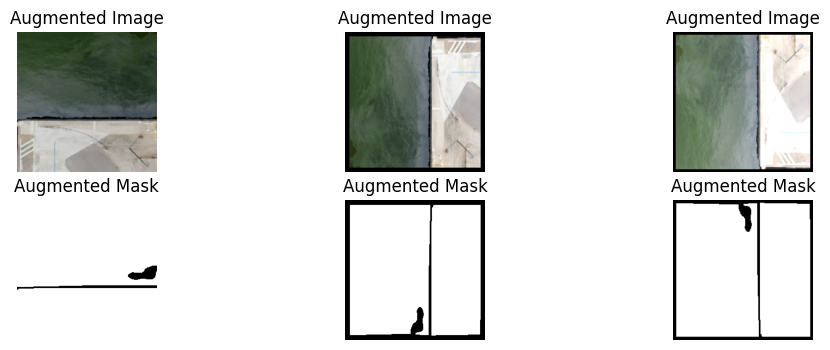

In [27]:
# ----------------------------
# 7. Test visualization of augmentations
# ----------------------------
def show_augmentations(img_path, mask_path, n=3):
    img, mask = parse_image_mask(img_path, mask_path)
    plt.figure(figsize=(12, 4))
    for i in range(n):
        aug_img, aug_mask = augment_image_mask(img, mask)
        plt.subplot(2, n, i+1)
        plt.imshow(aug_img.numpy())
        plt.axis("off")
        plt.title("Augmented Image")

        plt.subplot(2, n, i+1+n)
        plt.imshow(aug_mask.numpy().squeeze(), cmap="gray")
        plt.axis("off")
        plt.title("Augmented Mask")
    plt.show()

show_augmentations(train_img_paths[0], train_mask_paths[0])

In [28]:
import tensorflow as tf
from tensorflow.keras import layers, Model, backend as K

In [29]:
# ---------------------------
# Helper blocks
# ---------------------------
def conv_block(x, filters, kernel_size=3, activation="relu", batchnorm=True):
    x = layers.Conv2D(filters, kernel_size, padding="same", kernel_initializer="he_normal")(x)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)

    x = layers.Conv2D(filters, kernel_size, padding="same", kernel_initializer="he_normal")(x)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    return x

def encoder_block(x, filters, pool_size=(2,2), dropout=0.0):
    c = conv_block(x, filters)
    p = layers.MaxPooling2D(pool_size)(c)
    if dropout and dropout > 0:
        p = layers.Dropout(dropout)(p)
    return c, p

def decoder_block(x, skip, filters, kernel_size=3, strides=(2,2)):
    # Use Conv2DTranspose for learned upsampling (alternatively UpSampling2D + Conv)
    x = layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding="same")(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

In [30]:
# ---------------------------
# U-Net builder
# ---------------------------
def build_unet(input_shape=(256,256,3), base_filters=32, dropout=0.1):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1, p1 = encoder_block(inputs, base_filters)
    c2, p2 = encoder_block(p1, base_filters*2)
    c3, p3 = encoder_block(p2, base_filters*4)
    c4, p4 = encoder_block(p3, base_filters*8)

    # Bottleneck
    bn = conv_block(p4, base_filters*16)
    bn = layers.Dropout(dropout*2)(bn)

    # Decoder
    d4 = decoder_block(bn, c4, base_filters*8)
    d3 = decoder_block(d4, c3, base_filters*4)
    d2 = decoder_block(d3, c2, base_filters*2)
    d1 = decoder_block(d2, c1, base_filters)

    # Output
    outputs = layers.Conv2D(1, (1,1), padding="same", activation="sigmoid")(d1)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [31]:
# ---------------------------
# Losses & metrics
# ---------------------------
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_pred = K.cast(y_pred > 0.5, 'float32')
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)


In [32]:
# ---------------------------
# Build & compile
# ---------------------------
input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)  # from your preprocessing
model = build_unet(input_shape=input_shape, base_filters=32, dropout=0.1)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=bce_dice_loss,
              metrics=[dice_coef, iou_metric, "accuracy"])

model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │      9,248 │ activation_18[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ activation_19[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │     36,928 │ activation_20[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ activation_21[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_23[0][0] 

 Total params: 8,642,273 (32.97 MB)

 Trainable params: 8,636,385 (32.95 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [33]:
# ---------------------------
# Callbacks (recommended)
# ---------------------------
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("unet_oilspil.h5", save_best_only=True, monitor="val_iou_metric", mode="max"),
    tf.keras.callbacks.EarlyStopping(monitor="val_iou_metric", patience=12, restore_best_weights=True, mode="max"),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_iou_metric", factor=0.5, patience=4, min_lr=1e-7, mode="max")
]


In [34]:
# ---------------------------
# Training example
# ---------------------------
EPOCHS = 2
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/2
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.6376 - dice_coef: 0.6004 - iou_metric: 0.4816 - loss: 1.0216 

102/102 ━━━━━━━━━━━━━━━━━━━━ 1564s 15s/step - accuracy: 0.6385 - dice_coef: 0.6012 - iou_metric: 0.4828 - loss: 1.0199 - val_accuracy: 0.4820 - val_dice_coef: 0.4239 - val_iou_metric: 0.1470 - val_loss: 1.4196 - learning_rate: 1.0000e-04
Epoch 2/2
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.8067 - dice_coef: 0.7683 - iou_metric: 0.7218 - loss: 0.6614 

102/102 ━━━━━━━━━━━━━━━━━━━━ 1507s 15s/step - accuracy: 0.8067 - dice_coef: 0.7683 - iou_metric: 0.7218 - loss: 0.6612 - val_accuracy: 0.6308 - val_dice_coef: 0.5257 - val_iou_metric: 0.4045 - val_loss: 1.2882 - learning_rate: 1.0000e-04


In [35]:
# After training, evaluate on test set:
test_results = model.evaluate(test_dataset)
print("Test results (loss, dice, iou, acc):", test_results)

32/32 ━━━━━━━━━━━━━━━━━━━━ 120s 4s/step - accuracy: 0.5896 - dice_coef: 0.5488 - iou_metric: 0.4086 - loss: 1.3274
Test results (loss, dice, iou, acc): [1.3327561616897583, 0.5246809124946594, 0.38640260696411133, 0.606102705001831]
